<a href="https://colab.research.google.com/github/BreakoutMentors/Data-Science-and-Machine-Learning/blob/adam-medical-cnn/Intro_to_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import os
files.upload()
os.system("mkdir -p ~/.kaggle")
os.system("cp kaggle.json ~/.kaggle/")
os.system("chmod 600 ~/.kaggle/kaggle.json")

!kaggle datasets download -d preetviradiya/covid19-radiography-dataset
!unzip covid19-radiography-dataset.zip && rm covid19-radiography-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-671.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-6

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL

dataframe = pd.read_csv("/content/metadata.csv")
dataframe.head()

,Unnamed: 0,file_name,image_data_grayscale,file_format,image_shape,label
0,0,COVID-1.png,[[185 40 0 ... 0 24 131]\n [ 75 14 0 ...,PNG,"(299, 299)",COVID
1,1,COVID-10.png,[[135 133 131 ... 24 21 19]\n [132 130 129 ...,PNG,"(299, 299)",COVID
2,2,COVID-100.png,[[ 62 10 0 ... 197 200 209]\n [ 35 6 0 ...,PNG,"(299, 299)",COVID
3,3,COVID-1000.png,[[162 162 162 ... 4 4 5]\n [ 26 26 26 ...,PNG,"(299, 299)",COVID
4,4,COVID-1001.png,[[ 0 0 0 ... 0 0 0]\n [ 0 0 0 ...,PNG,"(299, 299)",COVID


In [60]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

root = "/content/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset"

means = (0.485, 0.456, 0.406)
stds = (0.229, 0.224, 0.225)

# Add more transforms tomorrow
transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(means, stds), # Means and STDs of ImageNet
])

# Using ImageFolder to read in the images with their labeled folders
dataset = ImageFolder(root, transform=transforms)

# Calculating the amount of images to split the dataset
trainToTestRatio = 0.8
trainSize = int(trainToTestRatio * len(dataset))
testSize = len(dataset) - trainSize

# Calculating the amount to split the training set into validation set
valSize = int(trainSize * 0.1) # Taking 10% of training data
trainSize = trainSize - valSize # Updating the amount of training data

# Splitting Data
training_data, val_data, testing_data = torch.utils.data.random_split(dataset, lengths=[trainSize, valSize, testSize])

# Loading Data
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

loaders = {'train':train_dataloader, 'valid':val_dataloader, 'test':test_dataloader}
datasets = {'train':training_data, 'valid':val_data, 'test':testing_data}

Batch Image Dimensions: torch.Size([16, 3, 224, 224])
Batch Label Dimensions: torch.Size([16])


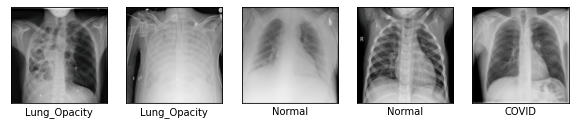

In [61]:
import torchvision.transforms.functional as F

# Function to reverse normalization of the images
def unNormalizeTensor(tensor, means, stds):
  for channel, mean, std in zip(tensor, means, stds):
    channel.mul_(std).add_(mean)
  return tensor

images, labels = next(iter(train_dataloader))
print("Batch Image Dimensions:", images.size())
print("Batch Label Dimensions:", labels.size())

idx_to_class = {value:key for key,value in dataset.class_to_idx.items()}
plt.figure(figsize=(10, 9))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image = F.to_pil_image(unNormalizeTensor(images[i], means, stds))
  plt.imshow(image)
  plt.xlabel(idx_to_class[labels[i].item()])

In [62]:
dataset.class_to_idx

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [63]:
import torch.nn as nn

class CNN_Model(nn.Module):
  
  # Constructing model
  def __init__(self):
    super(CNN_Model, self).__init__()

    # Defining Batch Normalization
    self.norm = nn.BatchNorm2d(num_features=3)

    # Defining Convolutional Layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, padding=1, stride=1) # Output Dimensions = (12, 224, 224)
    self.conv2 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, padding=1, stride=1)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, padding=1, stride=1)
    
    # Defining MaxPool Layer
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Defining Fully Connected Layers
    self.fc1 = nn.Linear(self.conv3.out_channels * 28 * 28, 3920) # Input Dimensions before Flattening = (20, 28, 28)
    self.fc2 = nn.Linear(3920, 980)
    self.fc3 = nn.Linear(980, 245)
    self.fc4 = nn.Linear(245, 62)
    self.fc5 = nn.Linear(62, 4) # Output Layer with 4 ending nodes for the four classes

    # Activation Function to use throughout
    self.relu = nn.ReLU()

    # Dropout to prevent overfitting
    self.dropout = nn.Dropout(p=0.5)
  
  def forward(self, input):
    
    # Batch Normalization for faster training
    x = self.norm(input)

    # First Convolutional Layer 
    x = self.relu(self.conv1(x)) # Output Shape = (12, 224, 224)
    x = self.maxpool(x) # Output Shape = (12, 112, 112)

    # Second Convolutional Layer
    x = self.relu(self.conv2(x)) # Output Shape = (16, 112, 112)
    x = self.maxpool(x) # Output Shape = (16, 56, 56)

    # Third Convolutional Lay
    x = self.relu(self.conv3(x)) # Output Shape = (20, 56, 56)
    x = self.maxpool(x) # Output Shape = (20, 28, 28)

    # Flattening Tensor
    x = x.view(-1, 20*28*28)

    # Fully Connected Layers
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.relu(self.fc3(x))
    x = self.dropout(x)
    x = self.relu(self.fc4(x))
    x = self.fc5(x)

    return x

In [64]:
print(model.parameters)

<bound method Module.parameters of CNN_Model(
  (norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=15680, out_features=3920, bias=True)
  (fc2): Linear(in_features=3920, out_features=980, bias=True)
  (fc3): Linear(in_features=980, out_features=245, bias=True)
  (fc4): Linear(in_features=245, out_features=62, bias=True)
  (fc5): Linear(in_features=62, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)>


In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Intializing model and having it use a GPU if available
model = CNN_Model()
model.to(device)

# Defining Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Defining Loss Function
criterion = nn.CrossEntropyLoss()


In [66]:
def train(n_epochs, loaders, datasets, model, optimizer, criterion, device, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for images, labels in loaders['train']:
            # move to GPU if available
            images, labels = images.to(device), labels.to(device)
            
            #Zero the parameter gradients
            optimizer.zero_grad()
            
            #Calculating the output
            output = model(images)
            
            #Caluculating the Loss
            loss = criterion(output, labels)
            
            #Calculating the gradients
            loss.backward()
            
            #Performing Gradient Descent Step
            optimizer.step()
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            train_loss += loss.data
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for images, labels in loaders['valid']:
            # move to GPU if available
            images, labels = images.to(device), labels.to(device)
            
            #Getting the output
            output = model(images)
            
            #Calculating the Loss
            loss = criterion(output, labels)
            
            ## update the average validation loss
            valid_loss += loss.data

        # Averaging the losses
        train_loss /= len(datasets['train'])
        valid_loss /= len(datasets['valid'])
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Saving Model')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

num_epochs=10

model = train(10, loaders, datasets, model, optimizer, criterion, device, 'saved_model.pt')

Epoch: 1 	Training Loss: 0.083696 	Validation Loss: 0.081023
Saving Model
Epoch: 2 	Training Loss: 0.079614 	Validation Loss: 0.077796
Saving Model
Epoch: 3 	Training Loss: 0.077279 	Validation Loss: 0.075901
Saving Model
Epoch: 4 	Training Loss: 0.075911 	Validation Loss: 0.074744
Saving Model
Epoch: 5 	Training Loss: 0.075086 	Validation Loss: 0.073954
Saving Model
Epoch: 6 	Training Loss: 0.074480 	Validation Loss: 0.073235
Saving Model
Epoch: 7 	Training Loss: 0.073777 	Validation Loss: 0.072154
Saving Model
Epoch: 8 	Training Loss: 0.072390 	Validation Loss: 0.069606
Saving Model
Epoch: 9 	Training Loss: 0.068432 	Validation Loss: 0.062489
Saving Model
Epoch: 10 	Training Loss: 0.062248 	Validation Loss: 0.057485
Saving Model
